# Este script sirve para preprocesar el dataset, se divide en 80% de training y 20% de test.
# Se carga el tokenizador con BERT
# Se convierten los datos tokenizados a tensores de PyTorch

In [2]:
# Bibliotecas estándar y de entorno
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Transformers (HuggingFace)
from transformers import AutoTokenizer, AutoConfig, BertForSequenceClassification
import torch.optim as optim  # Usar AdamW desde torch
# Barra de progreso
from tqdm import tqdm
# Validación y métricas
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

# ================== PREPROCESAMIENTO Y DIVISIÓN ==================

# Definir el nombre del modelo preentrenado
#MODEL_NAME = "bert-base-multilingual-cased"
#MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
MODEL_NAME = "finiteautomata/beto-sentiment-analysis"

# Crear directorio de salida para guardar archivos
output_dir = "Modelo_BERT"
os.makedirs(output_dir, exist_ok=True)

# Ruta del archivo con el dataset consolidado
file_path = "Clasificacion_Manual_Dataset_Etiquetado/Dataset_Emociones_Completo.csv"
print(f"Cargando dataset desde: {file_path}")
df = pd.read_csv(file_path, encoding='utf-8')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas")

# Crear una copia de la columna original de emociones en texto
# Esto permite conservar el nombre de la emoción aún después del mapeo numérico
df["Emocion_Textual"] = df["Emocion"]

# Codificar emociones en orden alfabético para garantizar consistencia reproducible
etiquetas_ordenadas = sorted(df["Emocion_Textual"].unique())
emocion_labels = {etq: idx for idx, etq in enumerate(etiquetas_ordenadas)}  # {'Alegría':0, 'Ira':1, ...}
reverse_labels = {idx: etq for etq, idx in emocion_labels.items()}  # {0:'Alegría', 1:'Ira', ...}
df["Emocion"] = df["Emocion_Textual"].map(emocion_labels)
NUM_LABELS = len(emocion_labels)

# Guardar el mapeo emoción → índice como archivo JSON para futura referencia
tags_path = os.path.join(output_dir, "emocion_labels.json")
with open(tags_path, "w", encoding="utf-8") as f:
    json.dump(emocion_labels, f, ensure_ascii=False, indent=4)

# Imprimir en consola el mapeo generado y el orden de etiquetas
print("\nMapeo emoción → índice:")
for k, v in emocion_labels.items():
    print(f"{k} → {v}")

print("\nOrden general del vector de emociones:")
for idx in range(NUM_LABELS):
    print(f"{idx} → {reverse_labels[idx]}")

# Dividir el dataset en entrenamiento (80%) y prueba (20%) de manera estratificada
print("\nDividiendo el dataset en entrenamiento (80%) y prueba (20%)...")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Texto_Procesado"].tolist(),  # Lista de textos
    df["Emocion"].tolist(),          # Lista de etiquetas codificadas
    test_size=0.2,                   # Porcentaje de prueba
    stratify=df["Emocion"],         # Preservar distribución de clases
    random_state=42                 # Semilla para reproducibilidad
)
print(f"Entrenamiento: {len(train_texts)} muestras | Prueba: {len(test_texts)} muestras")

# Guardar los conjuntos de entrenamiento y prueba en archivos CSV
pd.DataFrame({"Texto_Procesado": train_texts, "Emocion": train_labels}).to_csv(
    os.path.join(output_dir, "Train_Dataset.csv"), index=False, encoding='utf-8'
)
pd.DataFrame({"Texto_Procesado": test_texts, "Emocion": test_labels}).to_csv(
    os.path.join(output_dir, "Test_Dataset.csv"), index=False, encoding='utf-8'
)
print("Archivos CSV de entrenamiento y prueba guardados.")

# Cargar el tokenizador del modelo BERT especificado
print(f"\nCargando tokenizador: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True  # Ignora y reemplaza la capa final
)

# Función para tokenizar textos y convertirlos en tensores compatibles con PyTorch
def tokenizar_y_tensorizar(texts, labels):
    encodings = tokenizer(
        texts,
        truncation=True,        # Cortar textos largos
        padding=True,           # Rellenar textos cortos
        max_length=128,         # Longitud máxima
        return_tensors="pt"     # Retornar tensores de PyTorch
    )
    return TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels))

# Aplicar tokenización y conversión a tensores
print("Tokenizando y convirtiendo a tensores...")
train_data = tokenizar_y_tensorizar(train_texts, train_labels)
test_data = tokenizar_y_tensorizar(test_texts, test_labels)

# Definir tamaño de lote
BATCH_SIZE = 16

# Crear DataLoaders para manejo eficiente durante entrenamiento y evaluación
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print("Preprocesamiento completado. Datos listos para entrenamiento.\n")

Cargando dataset desde: Clasificacion_Manual_Dataset_Etiquetado/Dataset_Emociones_Completo.csv
Dataset cargado con 2880 filas y 6 columnas

Mapeo emoción → índice:
Estrés → 0
Felicidad → 1
Ira → 2
Miedo → 3
Preocupación → 4
Tristeza → 5

Orden general del vector de emociones:
0 → Estrés
1 → Felicidad
2 → Ira
3 → Miedo
4 → Preocupación
5 → Tristeza

Dividiendo el dataset en entrenamiento (80%) y prueba (20%)...
Entrenamiento: 2304 muestras | Prueba: 576 muestras
Archivos CSV de entrenamiento y prueba guardados.

Cargando tokenizador: finiteautomata/beto-sentiment-analysis


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at finiteautomata/beto-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizando y convirtiendo a tensores...
Preprocesamiento completado. Datos listos para entrenamiento.



# En esta fase se presenta el Script para el entrenamiento del modelo BERT

In [3]:
# ================== ENTRENAMIENTO DEL MODELO (ACTUALIZADO) ==================

import os
import json
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    get_scheduler
)

# ===================== PARÁMETROS =====================

output_dir = "Modelo_BERT"
MODEL_NAME = "finiteautomata/beto-sentiment-analysis"
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

# ===================== CARGA DE ETIQUETAS =====================

tags_path = os.path.join(output_dir, "emocion_labels.json")
with open(tags_path, "r", encoding="utf-8") as f:
    emocion_labels = json.load(f)
reverse_labels = {int(v): k for k, v in emocion_labels.items()}
NUM_LABELS = len(emocion_labels)

# ===================== DISPOSITIVO =====================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ===================== TOKENIZADOR Y MODELO =====================

print(f"Cargando tokenizador y configuración desde: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config,
    ignore_mismatched_sizes=True  # Para ajustar la capa de clasificación
)
model.to(device)

# ===================== OPTIMIZADOR Y FUNCIÓN DE PÉRDIDA =====================

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# ===================== CARGA DEL DATASET =====================

train_df = pd.read_csv(os.path.join(output_dir, "Train_Dataset.csv"), encoding='utf-8')
test_df = pd.read_csv(os.path.join(output_dir, "Test_Dataset.csv"), encoding='utf-8')

print(f"Datos de entrenamiento: {len(train_df)} | Datos de prueba: {len(test_df)}")

# ===================== TOKENIZACIÓN Y TENSORES =====================

def convert_to_tensor_dataset(df):
    encodings = tokenizer(
        df['Texto_Procesado'].tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = torch.tensor(df['Emocion'].values, dtype=torch.long)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

train_data = convert_to_tensor_dataset(train_df)
test_data = convert_to_tensor_dataset(test_df)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# ===================== SCHEDULER =====================

scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * EPOCHS
)

# ===================== MÉTRICAS =====================

epochs_list = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# ===================== FUNCIONES AUXILIARES =====================

def train_model(model, dataloader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Entrenando", unit="batch", leave=False):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_function(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(dataloader), correct / total

def evaluate_model(model, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluando", unit="batch", leave=False):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_function(outputs.logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(dataloader), correct / total

# ===================== ENTRENAMIENTO =====================

def run_training():
    for epoch in range(EPOCHS):
        print(f"\n===== Época {epoch + 1} de {EPOCHS} =====")
        train_loss, train_acc = train_model(model, train_dataloader)
        test_loss, test_acc = evaluate_model(model, test_dataloader)

        print(f"Entrenamiento - Pérdida: {train_loss:.4f}, Exactitud: {train_acc:.4f}")
        print(f"Prueba       - Pérdida: {test_loss:.4f}, Exactitud: {test_acc:.4f}")

        epochs_list.append(epoch + 1)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    model_save_path = os.path.join(output_dir, "BERT_Emociones_Model.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo entrenado guardado en: {model_save_path}")

# ===================== EJECUCIÓN =====================

run_training()

Usando dispositivo: cpu
Cargando tokenizador y configuración desde: finiteautomata/beto-sentiment-analysis


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at finiteautomata/beto-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Datos de entrenamiento: 2304 | Datos de prueba: 576

===== Época 1 de 5 =====


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Entrenamiento - Pérdida: 0.9626, Exactitud: 0.6372
Prueba       - Pérdida: 0.6751, Exactitud: 0.7344

===== Época 2 de 5 =====


Entrenamiento - Pérdida: 0.4763, Exactitud: 0.8303
Prueba       - Pérdida: 0.6253, Exactitud: 0.7795

===== Época 3 de 5 =====


Entrenamiento - Pérdida: 0.2833, Exactitud: 0.9132
Prueba       - Pérdida: 0.6522, Exactitud: 0.7847

===== Época 4 de 5 =====


Entrenamiento - Pérdida: 0.1660, Exactitud: 0.9501
Prueba       - Pérdida: 0.6873, Exactitud: 0.7934

===== Época 5 de 5 =====


Entrenamiento - Pérdida: 0.1200, Exactitud: 0.9670
Prueba       - Pérdida: 0.7041, Exactitud: 0.7951
Modelo entrenado guardado en: Modelo_BERT/BERT_Emociones_Model.pth


# Script para la fase de evaluación del modelo usando BERT

Cargando configuración...
Cargando tokenizador...
Inicializando modelo...
Cargando pesos entrenados desde Modelo_BERT/BERT_Emociones_Model.pth...
Modelo cargado correctamente.


Evaluando: 100%|██████████| 36/36 [00:14<00:00,  2.48batch/s]



===== Métricas de Evaluación =====
Accuracy : 0.7951
Precision: 0.7773
Recall   : 0.7749
F1-Score : 0.7755
ROC-AUC  : 0.9552
Métricas guardadas en: Modelo_BERT/metricas_evaluacion.txt


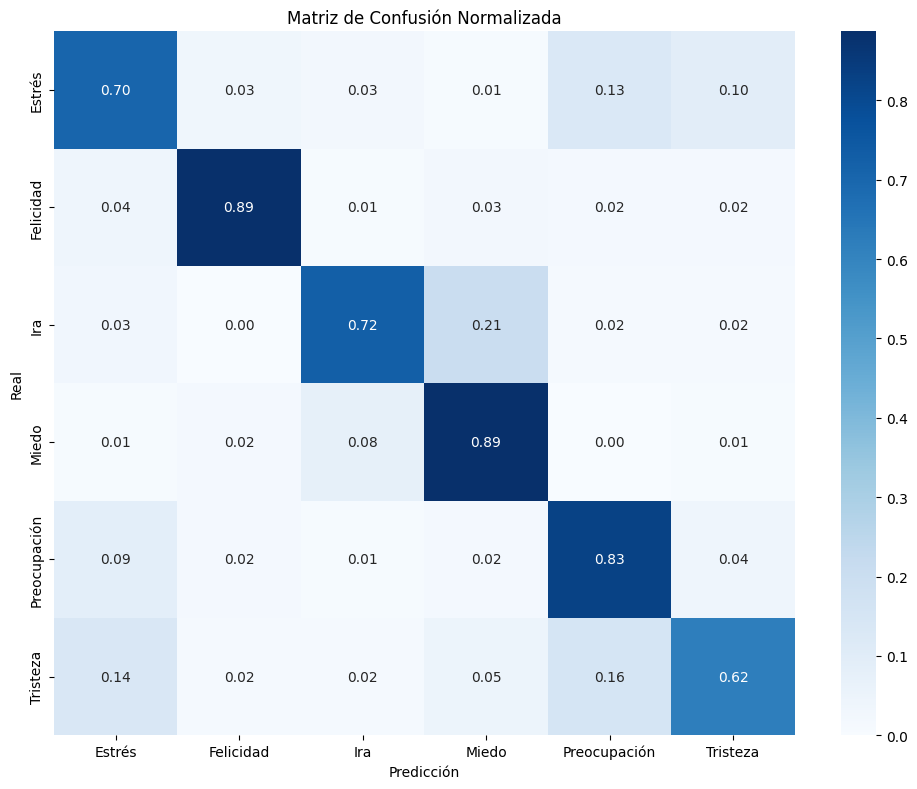

Matriz de confusión guardada en: Modelo_BERT/matriz_confusion.png

Texto de ejemplo: Hoy me siento realmente feliz y emocionado por mi logro
Emoción predicha: Felicidad


In [6]:
# ================== EVALUACIÓN DEL MODELO ==================

import os
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_auc_score
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

# ================== CONFIGURACIÓN ==================

# Directorio donde se encuentran los archivos del modelo y los datos
output_dir = "Modelo_BERT"
# Nombre del modelo preentrenado en HuggingFace
MODEL_NAME = "finiteautomata/beto-sentiment-analysis"
# Ruta del archivo con el mapeo de etiquetas
etiquetas_path = os.path.join(output_dir, "emocion_labels.json")

# Cargar etiquetas desde archivo JSON
with open(etiquetas_path, "r", encoding="utf-8") as f:
    emocion_labels = json.load(f)

# Crear diccionario inverso para mapear índices a etiquetas
reverse_labels = {int(v): k for k, v in emocion_labels.items()}
NUM_LABELS = len(emocion_labels)  # Número total de clases

# Detectar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================== CARGA DE MODELO Y TOKENIZADOR ==================

print("Cargando configuración...")
# Cargar configuración del modelo ajustando el número de etiquetas
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

print("Cargando tokenizador...")
# Cargar el tokenizador correspondiente al modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Inicializando modelo...")
# Inicializar el modelo con la configuración cargada (sin pesos todavía)
model = AutoModelForSequenceClassification.from_config(config)

# Ruta del archivo con los pesos entrenados
modelo_path = os.path.join(output_dir, "BERT_Emociones_Model.pth")
print(f"Cargando pesos entrenados desde {modelo_path}...")
# Cargar pesos entrenados al modelo
model.load_state_dict(torch.load(modelo_path, map_location=device))
model.to(device)  # Enviar modelo al dispositivo disponible
model.eval()  # Cambiar a modo evaluación
print("Modelo cargado correctamente.")

# ================== CARGA DE DATOS ==================

# Leer conjunto de prueba desde CSV
test_df = pd.read_csv(os.path.join(output_dir, "Test_Dataset.csv"), encoding='utf-8')

# Función para convertir un DataFrame en un TensorDataset compatible con PyTorch
def convert_to_tensor_dataset(df):
    encodings = tokenizer(
        df['Texto_Procesado'].tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = torch.tensor(df['Emocion'].values)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

BATCH_SIZE = 16
# Crear dataset y dataloader para el conjunto de prueba
test_data = convert_to_tensor_dataset(test_df)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# ================== FUNCIÓN DE EVALUACIÓN ==================

def evaluar_modelo(dataloader):
    all_preds = []
    all_labels = []
    all_probs = []

    # Desactivar gradientes para acelerar y reducir memoria durante inferencia
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluando", unit="batch"):
            # Enviar batch al dispositivo (GPU/CPU)
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            # Obtener predicciones
            outputs = model(input_ids, attention_mask=attention_mask)
            # Aplicar softmax para obtener probabilidades
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
            # Obtener etiquetas predichas
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            # Acumular resultados
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calcular métricas globales
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    # Mostrar métricas en consola
    print("\n===== Métricas de Evaluación =====")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"ROC-AUC  : {auc_score:.4f}")

    # Guardar métricas en archivo
    resultados_path = os.path.join(output_dir, "metricas_evaluacion.txt")
    with open(resultados_path, "w", encoding='utf-8') as f:
        f.write("===== Métricas de Evaluación =====\n")
        f.write(f"Accuracy : {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall   : {recall:.4f}\n")
        f.write(f"F1-Score : {f1:.4f}\n")
        f.write(f"ROC-AUC  : {auc_score:.4f}\n")
    print(f"Métricas guardadas en: {resultados_path}")

    # Generar matriz de confusión normalizada
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=[reverse_labels[i] for i in range(NUM_LABELS)],
        yticklabels=[reverse_labels[i] for i in range(NUM_LABELS)]
    )
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión Normalizada")
    cm_path = os.path.join(output_dir, "matriz_confusion.png")
    plt.tight_layout()
    plt.savefig(cm_path, dpi=300)
    plt.show()
    plt.close()
    print(f"Matriz de confusión guardada en: {cm_path}")

# ================== PREDICCIÓN DE EMOCIONES NUEVAS ==================

# Función para predecir la emoción de un texto nuevo
def predecir_emocion(texto: str) -> str:
    model.eval()  # Asegurarse que el modelo esté en modo evaluación
    # Tokenizar y preparar entrada
    inputs = tokenizer(texto, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():  # Sin gradientes para evaluación
        outputs = model(**inputs)
        logits = outputs.logits
        # Obtener etiqueta con mayor probabilidad
        pred_label = int(torch.argmax(logits, dim=1).item())
    return reverse_labels.get(pred_label, f"Desconocido ({pred_label})")

# ================== EJECUCIÓN ==================

if __name__ == "__main__":
    evaluar_modelo(test_dataloader)  # Ejecutar evaluación completa
    ejemplo = "Hoy me siento realmente feliz y emocionado por mi logro"  # Texto de prueba
    pred = predecir_emocion(ejemplo)  # Realizar predicción
    print(f"\nTexto de ejemplo: {ejemplo}")
    print(f"Emoción predicha: {pred}")


In [21]:
#Ingresar frase desde teclado para realizar predicción
# Interfaz para ingresar textos y obtener predicciones
import sys

print("\nIngrese una frase para evaluar su emoción. Escriba 'salir' para terminar.\n")
while True:
    #print("reverse_labels:", reverse_labels)
    texto_usuario = input("Texto: ")
    sys.stdout.flush()  # Forzar impresión inmediata
    print(texto_usuario)
    if texto_usuario.lower() == "salir":
        print("Saliendo del programa...")
        break
    
    emocion = predecir_emocion(texto_usuario)
    print(f"La emoción predicha es: {emocion}\n")


Ingrese una frase para evaluar su emoción. Escriba 'salir' para terminar.

Estoy avanzando en mi trabajo del doctorado porque la presentación es la otra semana.
La emoción predicha es: Estrés

Estoy feliz porque ya acabó el semestre.
La emoción predicha es: Ira

Feliz
La emoción predicha es: Felicidad


La emoción predicha es: Felicidad

salir
Saliendo del programa...


In [5]:
# ================== APLICACIÓN GRÁFICA DE PREDICCIÓN ==================

import tkinter as tk  # Librería para crear la interfaz gráfica
from tkinter import messagebox  # Para mostrar mensajes emergentes
import logging  # Para registrar eventos y resultados
from datetime import datetime  # Para incluir fecha y hora en los logs
import os  # Para verificar la existencia del archivo de logs

# Configuración del archivo de log con fecha y hora
LOG_FILE = "registro_predicciones.log"
logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    encoding='utf-8'
)

# Crear ventana principal
ventana = tk.Tk()
ventana.title("Predicción de Emoción con BERT")
ventana.geometry("500x300")
ventana.resizable(False, False)
ventana.configure(bg="white")  # Fondo blanco para toda la ventana

# Función para realizar la predicción de la emoción desde la interfaz gráfica
def predecir_desde_interfaz():
    texto = entrada_texto.get("1.0", tk.END).strip()
    if texto.lower() == "salir":
        ventana.destroy()  # Cerrar la aplicación si el usuario escribe "salir"
    elif texto:
        emocion = predecir_emocion(texto)  # Obtener emoción predicha
        etiqueta_resultado.config(text=f"Emoción predicha: {emocion}")
        print(f"Texto ingresado: {texto}")  # Mostrar entrada en consola
        print(f"Emoción predicha: {emocion}")  # Mostrar predicción en consola
        # Registrar en archivo de log con fecha y hora
        logging.info(f"Texto ingresado: {texto}")
        logging.info(f"Emoción predicha: {emocion}")
    else:
        messagebox.showwarning("Entrada vacía", "Por favor, ingrese una frase para evaluar.")

# Función para limpiar el texto del input y el resultado
def limpiar_entrada():
    entrada_texto.delete("1.0", tk.END)
    etiqueta_resultado.config(text="")

# Etiqueta de instrucciones
etiqueta_instruccion = tk.Label(
    ventana,
    text="Ingrese una frase para evaluar su emoción:",
    font=("Arial", 12),
    bg="white",
    fg="black"
)
etiqueta_instruccion.pack(pady=10)

# Área de texto para ingresar la frase
entrada_texto = tk.Text(
    ventana,
    height=4,
    width=50,
    font=("Arial", 11),
    bg="white",
    fg="black"
)
entrada_texto.pack(pady=5)

# Botón para ejecutar la predicción
boton_predecir = tk.Button(
    ventana,
    text="Predecir emoción",
    command=predecir_desde_interfaz,
    font=("Arial", 12)
)
boton_predecir.pack(pady=5)

# Botón para limpiar entrada
boton_limpiar = tk.Button(
    ventana,
    text="Limpiar",
    command=limpiar_entrada,
    font=("Arial", 12)
)
boton_limpiar.pack(pady=5)

# Etiqueta para mostrar el resultado de la predicción
etiqueta_resultado = tk.Label(
    ventana,
    text="",
    font=("Arial", 12, "bold"),
    bg="white",
    fg="black"
)
etiqueta_resultado.pack(pady=10)

# Ejecutar la aplicación gráfica
try:
    ventana.mainloop()
finally:
    # Al cerrar la aplicación, verificar si el archivo de logs se creó correctamente
    if os.path.exists(LOG_FILE):
        print(f"\nEl archivo de logs '{LOG_FILE}' se ha generado correctamente.")
    else:
        print("\nError: No se pudo generar el archivo de logs.")


Texto ingresado: Ya es muy tarde, tengo sueño y aún no termino mi programa.
Emoción predicha: Estrés
Texto ingresado: Mi color favorito es el amarillo y quiero una playera.
Emoción predicha: Felicidad
Texto ingresado: Me duele la espalda de tanto trabajo que tengo.
Emoción predicha: Preocupación
Texto ingresado: Ya es hora de ir a dormir porque mañana tengo que trabajar.
Emoción predicha: Estrés
Texto ingresado: Me siento decaido porque no he podido ir a ver a mis papás.
Emoción predicha: Tristeza
Texto ingresado: La Dra Somodevilla quiere que le presente avances la siguiente semana de mi tesis.
Emoción predicha: Preocupación
Texto ingresado: Me abruma mucho el pensar en mi futuro.
Emoción predicha: Preocupación
Texto ingresado: Le tengo pánico a las alturas y a los bichos.
Emoción predicha: Preocupación
Texto ingresado: Me desagrada la comida muy grasosa.
Emoción predicha: Estrés
Texto ingresado: Me da asco la mayonesa en los platillos.
Emoción predicha: Preocupación
Texto ingresado: 